In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!pip uninstall tensorboard
!pip install  tf-nightly-2.0-preview

In [ ]:
!pip install grpcio==1.25.0

In [ ]:
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

from tensorflow import summary

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
cd ../GAT/

/content/drive/My Drive/Colab Notebooks/GAT


In [ ]:
#layers
import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        #self.weight.data.uniform_(-stdv, stdv)
        nn.init.xavier_uniform_(self.weight.data, gain=1)
        if self.bias is not None:
            #nn.init.xavier_uniform_(self.bias.data, gain=1)
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
+ str(self.out_features) + ')'

In [ ]:
#GCN
import torch.nn as nn
import torch.nn.functional as F



class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        #
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        y=x.clone()
        return F.log_softmax(x, dim=1),y

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.theta=nn.parameter(torch.nn.init.normal_(tensor, mean=0, std=1))

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        h = torch.mm(input, self.W)
        N = h.size()[0]

        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        
        #attention = torch.where(adj > 0, e, zero_vec)
        attention = torch.where(adj > self.theta, e, zero_vec)
        attention = F.softmax(attention, dim=1)  #normalization of attention score
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


class SpecialSpmmFunction(torch.autograd.Function):
    """Special function for only sparse region backpropataion layer."""
    @staticmethod
    def forward(ctx, indices, values, shape, b):
        assert indices.requires_grad == False
        a = torch.sparse_coo_tensor(indices, values, shape)
        ctx.save_for_backward(a, b)
        ctx.N = shape[0]
        return torch.matmul(a, b)

    @staticmethod
    def backward(ctx, grad_output):
        a, b = ctx.saved_tensors
        grad_values = grad_b = None
        if ctx.needs_input_grad[1]:
            grad_a_dense = grad_output.matmul(b.t())
            edge_idx = a._indices()[0, :] * ctx.N + a._indices()[1, :]
            grad_values = grad_a_dense.view(-1)[edge_idx]
        if ctx.needs_input_grad[3]:
            grad_b = a.t().matmul(grad_output)
        return None, grad_values, None, grad_b


class SpecialSpmm(nn.Module):
    def forward(self, indices, values, shape, b):
        return SpecialSpmmFunction.apply(indices, values, shape, b)

    
class SpGraphAttentionLayer(nn.Module):
    """
    Sparse version GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(SpGraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_normal_(self.W.data, gain=1)
                
        self.a = nn.Parameter(torch.zeros(size=(1, 2*out_features)))
        nn.init.xavier_normal_(self.a.data, gain=1)

        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.theta = torch.empty(1, 1)
        torch.nn.init.normal_(self.theta, mean=0.0, std=1.0)
        #self.theta=nn.parameter(torch.nn.init.normal_(theta, mean=0, std=1))

        self.special_spmm = SpecialSpmm()

    def forward(self, input, adj):
        dv = 'cuda' if input.is_cuda else 'cpu'

        N = input.size()[0]

        #zero_vec = -9e15*torch.ones_like(e)

        #nonzero_mask = np.array(adj[adj.nonzero()] < 3)

        assert not torch.isnan(input).any()
        assert not torch.isnan(self.W).any()


        edge = adj.nonzero().t()
        #print(edge)

        h = torch.mm(input, self.W)
        # h: N x out
        assert not torch.isnan(h).any()

        # Self-attention on the nodes - Shared attention mechanism
        edge_h = torch.cat((h[edge[0, :], :], h[edge[1, :], :]), dim=1).t()
        # edge: 2*D x E

        edge_e = torch.exp(-self.leakyrelu(self.a.mm(edge_h).squeeze()))

        assert not torch.isnan(edge_e).any()
        # edge_e: E

        e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N,1), device=dv))
        #print(e_rowsum[755:765])
        # e_rowsum: N x 1
        #print(np.sort(e_rowsum.clone().detach().numpy()))

        assert not torch.isnan(edge_e).any()#

        edge_e = self.dropout(edge_e)
        # edge_e: E

        assert not torch.isnan(edge_e).any()#

        h_prime = self.special_spmm(edge, edge_e, torch.Size([N, N]), h)

        zero_vec = -9e15*torch.ones_like(e_rowsum)

        e_rowsum=torch.where(e_rowsum > 0, e_rowsum, zero_vec)
        
        assert not torch.isnan(h_prime).any()
        # h_prime: N x out
        #print("X",h_prime[760])
        #print(h_prime)
        h_prime = h_prime.div(e_rowsum)
        #print("X",h_prime[760])
        # h_prime: N x out
        #xx=(h_prime!=h_prime)
        #print((xx==True).nonzero())

        assert not torch.isnan(h_prime).any()

        if self.concat:
            # if this layer is not last layer,
            return F.elu(h_prime)
        else:
            # if this layer is last layer,
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#from layers import GraphAttentionLayer, SpGraphAttentionLayer


class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        y=x.clone()
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1),y


class SpGAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Sparse version of GAT."""
        super(SpGAT, self).__init__()
        self.dropout = dropout
        

        self.attentions = [SpGraphAttentionLayer(nfeat, 
                                                 nhid, 
                                                 dropout=dropout, 
                                                 alpha=alpha, 
                                                 concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = SpGraphAttentionLayer(nhid * nheads, 
                                             nclass, 
                                             dropout=dropout, 
                                             alpha=alpha, 
                                             concat=False)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        y=x.clone()
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1),y


In [ ]:
"combine GCN and GAT"


class SpGATGCN(nn.Module):
    def __init__(self, nfeat, nhid1,nhid2, nclass, dropout, alpha, nheads):
        """Sparse version of GAT."""
        
        super(SpGATGCN, self).__init__()
        self.dropout = dropout
        self.gc1 = GraphConvolution(nfeat, nhid1)
        #self.add_module('Graph convolution layer_{ }'.format(1),self.gc1)
        #self.gc2 = GraphConvolution(nhid1+50, nhid1)

        self.attentions = [SpGraphAttentionLayer(nhid1, 
                                                 nhid2, 
                                                 dropout=dropout, 
                                                 alpha=alpha, 
                                                 concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = SpGraphAttentionLayer(nhid2 * nheads, 
                                             nclass, 
                                             dropout=dropout, 
                                             alpha=alpha, 
                                             concat=False)
        #for i, attention in enumerate(self.out_att):
        #self.add_module('attention_outer_{}'.format(1), self.out_att)
        

    def forward(self, x, adj):
        assert not torch.isnan(x).any()
        x = F.relu(self.gc1(x, adj))
        assert not torch.isnan(x).any()
        
        x = F.dropout(x, self.dropout, training=self.training)
        assert not torch.isnan(x).any()
        
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        assert not torch.isnan(x).any()
        x = F.dropout(x, self.dropout, training=self.training)
        assert not torch.isnan(x).any()
        y=x.clone()
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1),y

In [ ]:
"combine GCN and GAT"


class SpGATGCN1(nn.Module):
    def __init__(self, nfeat, nhid1,nhid2, nclass, dropout, alpha, nheads):
        """Sparse version of GAT."""
        
        super(SpGATGCN1, self).__init__()
        self.dropout = dropout
        self.gc1 = GraphConvolution(nfeat, nhid1)
        #self.add_module('Graph convolution layer_{ }'.format(1),self.gc1)
        #self.gc2 = GraphConvolution(nhid1+50, nhid1)

        self.attentions1 = [SpGraphAttentionLayer(nhid1, 
                                                 nhid2*4, 
                                                 dropout=dropout, 
                                                 alpha=alpha, 
                                                 concat=True) for _ in range(nheads)]

        self.attentions2 = [SpGraphAttentionLayer(nhid2*4*nheads, 
                                                 nhid2, 
                                                 dropout=dropout, 
                                                 alpha=alpha, 
                                                 concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions1):
            self.add_module('attention1_{}'.format(i), attention)
        for i, attention in enumerate(self.attentions2):
            self.add_module('attention2_{}'.format(i), attention)

        self.out_att = SpGraphAttentionLayer(nhid2 * nheads, 
                                             nclass, 
                                             dropout=dropout, 
                                             alpha=alpha, 
                                             concat=False)
        #for i, attention in enumerate(self.out_att):
        #self.add_module('attention_outer_{}'.format(1), self.out_att)
        

    def forward(self, x, adj):
        assert not torch.isnan(x).any()
        x = F.relu(self.gc1(x, adj))
        assert not torch.isnan(x).any()
        
        x = F.dropout(x, self.dropout, training=self.training)
        assert not torch.isnan(x).any()
        
        x = torch.cat([att(x, adj) for att in self.attentions1], dim=1)
        assert not torch.isnan(x).any()
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions2], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        y=x.clone()
        assert not torch.isnan(x).any()
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1),y

In [ ]:
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys
import re
import torch

def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


def load_corpus1(dataset_str):

    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'adj']
    objects = []
    for i in range(len(names)):
        with open("/content/drive/My Drive/Colab Notebooks/text_gat/data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, adj = tuple(objects)
    # print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)
    print("SHAPE ALLX",allx.shape,"shape tx",tx.shape)
    
    features = sp.vstack((allx, tx))
    features=sp.eye(features.shape[0])
    ##
    features = normalize_features(features)
    ##remember
    print("feature shape",features.shape)
    labels = np.vstack((ally, ty))
    
    # print(len(labels))

    train_idx_orig = parse_index_file(
        "/content/drive/My Drive/Colab Notebooks/text_gat/data/{}.train.index".format(dataset_str))
    train_size = len(train_idx_orig)

    val_size = train_size - x.shape[0]
    test_size = tx.shape[0]

    idx_train = range(len(y))
    idx_val = range(len(y), len(y) + val_size)
    idx_test = range(allx.shape[0], allx.shape[0] + test_size)
    
    labels=np.argmax(labels,axis=1)


    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    #symmetric features

    adj=normalize_adj(adj+ sp.eye(adj.shape[0]))
    adj = torch.FloatTensor(np.array(adj.todense()))
    features = torch.FloatTensor(np.array(features.todense()))
    #labels = torch.LongTensor(np.where(labels)[1])
    labels=torch.LongTensor(np.array(labels))
    
    
    print("Xz",labels.shape)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    #labels=np.argmax(labels, axis=0)

    return adj, features,labels,idx_train,idx_val,idx_test

def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

def normalize_features(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    # return sparse_to_tuple(features)
    return features.A


def normalize_adj_(adj):#kipf
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

def normalize_adj(mx):#velicovic
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    # return sparse_to_tuple(adj_normalized)
    return adj_normalized.A


def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i]
                      for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict




def loadWord2Vec(filename):
    """Read Word Vectors"""
    vocab = []
    embd = []
    word_vector_map = {}
    file = open(filename, 'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        if(len(row) > 2):
            vocab.append(row[0])
            vector = row[1:]
            length = len(vector)
            for i in range(length):
                vector[i] = float(vector[i])
            embd.append(vector)
            word_vector_map[row[0]] = vector
    print_log('Loaded Word Vectors!')
    file.close()
    return vocab, embd, word_vector_map

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


import datetime
def print_log(msg='', end='\n'):
    now = datetime.datetime.now()
    t = str(now.year) + '/' + str(now.month) + '/' + str(now.day) + ' ' \
      + str(now.hour).zfill(2) + ':' + str(now.minute).zfill(2) + ':' + str(now.second).zfill(2)

    if isinstance(msg, str):
        lines = msg.split('\n')
    else:
        lines = [msg]
        
    for line in lines:
        if line == lines[-1]:
            print('[' + t + '] ' + str(line), end=end)
        else: 
            print('[' + t + '] ' + str(line))


In [ ]:

def load_corpus(dataset_str):
    """
    Loads input corpus from gcn/data directory

    ind.dataset_str.x => the feature vectors of the training docs as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test docs as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training docs/words
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training docs as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test docs as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.adj => adjacency matrix of word/doc nodes as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.train.index => the indices of training docs in original doc list.

    All objects above must be saved using python pickle module.

    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """

    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'adj']
    objects = []
    for i in range(len(names)):
        with open("../data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, adj = tuple(objects)
    # print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)
    # print("SHAPE ALLX",allx.shape,"shape x",tx.shape)
    features = sp.vstack((allx, tx)).tolil()
    print("feature shape",features.shape)
    features=sp.eye(features.shape[0])
    ##
    features = normalize_features(features)

    labels = np.vstack((ally, ty))
    #print(labels)

    train_idx_orig = parse_index_file(
        "../data/{}.train.index".format(dataset_str))
    train_size = len(train_idx_orig)

    val_size = train_size - x.shape[0]
    test_size = tx.shape[0]

    idx_train = range(len(y))
    idx_val = range(len(y), len(y) + val_size)
    idx_test = range(allx.shape[0], allx.shape[0] + test_size)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj=normalize_adj(adj+ sp.eye(adj.shape[0]))

    #adj = torch.FloatTensor(np.array(adj.todense()))
    #features = torch.FloatTensor(np.array(features.todense()))

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size


In [ ]:
import numpy as np
import scipy.sparse as sp
import torch


def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot




def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)


def normalize_features(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


In [ ]:
from __future__ import division
from __future__ import print_function

import os
import glob
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


# Training settings
parser = argparse.ArgumentParser()
#parser = parser.parse_args(args=[])
parser.add_argument('--no-cuda', action='store_true', default=False, help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False, help='Validate during training pass.')
parser.add_argument('--sparse', action='store_true', default=True, help='GAT with sparse version or not.')
parser.add_argument('--seed', type=int, default=82, help='Random seed.')
parser.add_argument('--epochs', type=int, default=10000, help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=0.00001, help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=8, help='Number of hidden units.')
parser.add_argument('--nb_heads', type=int, default=8, help='Number of head attentions.')
parser.add_argument('--dropout', type=float, default=0.5, help='Dropout rate (1 - keep probability).')
parser.add_argument('--alpha', type=float, default=0.2, help='Alpha for the leaky_relu.')
parser.add_argument('--patience', type=int, default=100, help='Patience')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data
#adj, features, labels, idx_train, idx_val, idx_test = load_data()
#print(features)
adj, features, labels, idx_train, idx_val, idx_test = load_corpus1("R8")
print(args.hidden)
# Model and optimizer
if args.sparse:
    print("sparse")
    """model = GCN(nfeat=features.shape[1], 
                nhid=200, 
                nclass=int(labels.max()) + 1, 
                dropout=args.dropout)"""
    model = SpGATGCN(nfeat=features.shape[1], 
                nhid1=200, 
                nhid2=args.hidden,
                nclass=int(labels.max()) + 1, 
                dropout=args.dropout, 
                nheads=args.nb_heads, 
                alpha=args.alpha)
    """ model = SpGATGCN1(nfeat=features.shape[1], 
                nhid1=200, 
                nhid2=args.hidden,
                nclass=int(labels.max()) + 1, 
                dropout=args.dropout, 
                nheads=args.nb_heads, 
                alpha=args.alpha)"""
else:
    model = GAT(nfeat=features.shape[1], 
                nhid=args.hidden, 
                nclass=int(labels.max()) + 1, 
                dropout=args.dropout, 
                nheads=args.nb_heads, 
                alpha=args.alpha)
print(model)



SHAPE ALLX (13173, 300) shape tx (2189, 300)
feature shape (15362, 15362)
Xz torch.Size([15362])
8
sparse
SpGATGCN(
  (gc1): GraphConvolution (15362 -> 200)
  (attention_0): SpGraphAttentionLayer (200 -> 8)
  (attention_1): SpGraphAttentionLayer (200 -> 8)
  (attention_2): SpGraphAttentionLayer (200 -> 8)
  (attention_3): SpGraphAttentionLayer (200 -> 8)
  (attention_4): SpGraphAttentionLayer (200 -> 8)
  (attention_5): SpGraphAttentionLayer (200 -> 8)
  (attention_6): SpGraphAttentionLayer (200 -> 8)
  (attention_7): SpGraphAttentionLayer (200 -> 8)
  (out_att): SpGraphAttentionLayer (64 -> 8)
)


In [ ]:
optimizer = optim.Adam(model.parameters(), 
                       lr=args.lr, 
                       weight_decay=args.weight_decay)

if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

features, adj, labels = Variable(features), Variable(adj), Variable(labels)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output,y = model(features, adj)
    yyyy=output[idx_train]
    print(yyyy.shape)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])

    loss_train.backward()
    #torch.nn.utils.clip_grad_value_(model.parameters(),1)
    
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output,y = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test=accuracy(output[idx_test], labels[idx_test])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.data.item()),
          'acc_train: {:.4f}'.format(acc_train.data.item()),
          'loss_val: {:.4f}'.format(loss_val.data.item()),
          'acc_val: {:.4f}'.format(acc_val.data.item()),
          'loss_test: {:.4f}'.format(loss_test.data.item()),
          'acc_test: {:.4f}'.format(acc_test.data.item())
          'time: {:.4f}'.format(time.time() - t))
    with train_summary_writer.as_default():
           summary.scalar('val_loss', loss_val.data.item(), step=epoch)
           summary.scalar('train_loss', loss_train.data.item(), step=epoch)
           summary.scalar('train_acc', acc_train.data.item(), step=epoch)
           summary.scalar('val_acc', acc_val.data.item(), step=epoch)
    return loss_val.data.item(),acc_val.data.item(),acc_train.data.item(),loss_train.data.item(),loss_test.data.item(),acc_test.data.item()


def compute_test(best_epoch):
    model.eval()
    output,y = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.data.item()),
          "accuracy= {:.4f}".format(acc_test.data.item()))
    with test_summary_writer.as_default():
        summary.scalar('loss', loss_test.data.item(), step=best_epoch)
        summary.scalar('accuracy', acc_test, step=best_epoch)




# Testing

SyntaxError: ignored

In [ ]:
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)

In [ ]:
%tensorboard --logdir logs/tensorboard  #tensorboard

In [ ]:
# Train model
t_total = time.time()
loss_values = []
bad_counter = 0
best = args.epochs + 1
best_epoch = 0
metrics=[]
for epoch in range(args.epochs):
    loss_val,acc_val,acc_train,loss_train,loss_test,acc_test=train(epoch)
    metrics.append((loss_val,acc_val,acc_train,loss_train,loss_test,acc_test))

    loss_values.append(loss_val)
    torch.save(metrics,'metricsrR8.ax')

    torch.save(model.state_dict(), '{}.pkl'.format(epoch))
    if loss_values[-1] < best:
        best = loss_values[-1]
        best_epoch = epoch
        bad_counter = 0
    else:
        bad_counter += 1

    if bad_counter == args.patience:
        break

    files = glob.glob('*.pkl')
    for file in files:
        epoch_nb = int(file.split('.')[0])
        if epoch_nb < best_epoch:
            os.remove(file)

files = glob.glob('*.pkl')
for file in files:
    epoch_nb = int(file.split('.')[0])
    if epoch_nb > best_epoch:
        os.remove(file)

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

In [ ]:
import pandas as pd
df=pd.DataFrame(adj.clone().detach().numpy())
#sorted(df,reverse=False)
pd.DataFrame(df.sum(0)).to_csv("Filr.csv")

In [ ]:
import networkx as nx
G=nx.Graph()
G=nx.from_numpy_matrix(adj.clone().detach().numpy())

In [ ]:
print(G.number_of_edges())
print(G.number_of_nodes())
df=pd.DataFrame(G.degree())
sorted(df)
df.to_csv("degr.csv")
len(list(nx.connected_components(G)))

In [ ]:
nx.draw(G)

In [ ]:
import pkg_resources

for entry_point in pkg_resources.iter_entry_points('tensorboard_plugins'):
    print(entry_point.dist)

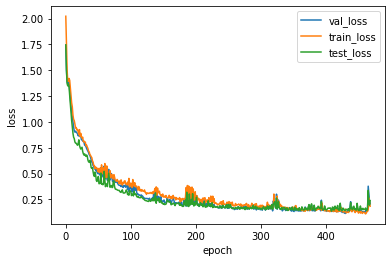

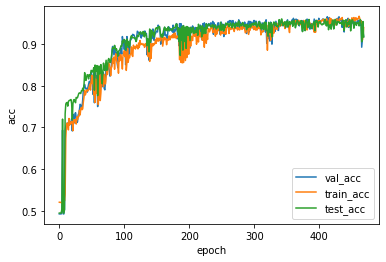

,a,b,c,d,e,f
0,1.746217,0.492701,0.520762,2.023114,1.745112,0.494746
1,1.508350,0.492701,0.520356,1.743895,1.502996,0.494746
2,1.386072,0.492701,0.520559,1.508666,1.372194,0.494746
3,1.374712,0.492701,0.519749,1.391821,1.349190,0.494746
4,1.404371,0.501825,0.520559,1.395021,1.366972,0.505254
...,...,...,...,...,...,...
464,0.156971,0.956204,0.955439,0.134386,0.166665,0.948835
465,0.378502,0.892336,0.952400,0.147905,0.337835,0.905436
466,0.298307,0.910584,0.909459,0.264869,0.223472,0.942896
467,0.231586,0.928832,0.920802,0.216684,0.194608,0.953860


In [ ]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

metric=torch.load('metricsrR8.ax')
df=pd.DataFrame(metric,columns=["a","b","c","d","e","f"])
col=df.columns
df1=df[col[0]]
df2=df[col[1]]
df3=df[col[2]]
df4=df[col[3]]
df5=df[col[4]]
df6=df[col[5]]
fig = plt.figure()
ax = plt.axes()

x = range(len(df.values))
plt.plot(x,df1.values,label="val_loss")
plt.plot(x,df4.values,label="train_loss")
plt.plot(x,df5.values,label="test_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("{}loss.png".format("R8"))
plt.show()

plt.plot(x,df2.values,label="val_acc")
plt.plot(x,df3.values,label="train_acc")
plt.plot(x,df6.values,label="test_acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.savefig("{}acc.png".format("R8"))
plt.show()
df

In [ ]:
col=df.columns
df[ df[col[2]]>0.96]

,a,b,c,d,e,f
411,0.160867,0.952555,0.960705,0.133428,0.174393,0.943353
416,0.153378,0.943431,0.962528,0.128381,0.172727,0.940155
418,0.166502,0.939781,0.960502,0.130869,0.191954,0.935587
427,0.133268,0.959854,0.960097,0.132334,0.162700,0.946094
431,0.125548,0.961679,0.961110,0.119711,0.154413,0.949292
434,0.143294,0.954380,0.960502,0.126168,0.156790,0.948378
435,0.154215,0.939781,0.963541,0.123559,0.161163,0.945637
445,0.149559,0.939781,0.960097,0.122820,0.162785,0.947008
450,0.143820,0.948905,0.962933,0.117656,0.144467,0.957515
453,0.157165,0.950730,0.963541,0.117495,0.186397,0.937871


In [ ]:
model.eval()
output,y = model(features, adj)
train_=y[idx_train]
val_=y[idx_val]
test_=y[idx_test]
docs=torch.cat([train_,val_,test_],dim=0)
idx=torch.cat([idx_train,idx_val,idx_test],dim=0)
print(idx.shape)
labell=labels[idx]


label=labels[idx_test]


#**********TSNE**************************************************************
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np
import os


fea = TSNE(n_components=2).fit_transform(test_.detach().numpy())
#pdf = PdfPages(data_set + '_gcn_doc_test.pdf')
cls = np.unique(labels)

# cls=range(10)
fea_num = [fea[label == i] for i in cls]
for i, f in enumerate(fea_num):
    if cls[i] in range(10):
        plt.scatter(f[:, 0], f[:, 1], label=cls[i], marker='+')
    else:
        plt.scatter(f[:, 0], f[:, 1], label=cls[i])
plt.legend(ncol=5, loc='upper center', bbox_to_anchor=(0.48, -0.08), fontsize=11)
# plt.ylim([-20,35])
# plt.title(md_file)
plt.tight_layout()
plt.savefig("R8test.png")
plt.show()
#pdf.close()